# Experiment Initialization

Here, the terms of the experiment are defined, such as the location of the files in S3 (bucket and folder name), and each of the video prefixes (everything before the file extension) that need to be tracked. 

Note that these videos should be similar-ish: while we can account for differences in mean intensities between videos, particle sizes should be approximately the same, and (slightly less important) particles should be moving at about the same order of magnitude speed. In this experiment, these videos were taken in 0.4% agarose gel at 100x magnification and 100.02 fps shutter speeds with nanoparticles of about 100nm in diameter.

In [1]:
to_track = [] # This is going to be the list of all filenames that will be included in the analysis
start_knot = 80 #Must be unique number for every run on Cloudknot.

remote_folder = '08_01_19_MPT_HYase_treated_HA_trial_2' # The folder in AWS S3 containing the files to be analyzed
bucket = 'mckenna.data' # The bucket in AWS S3 where the remote_folder is contained
NP_size = ['40','100']
vids = 5 # this is the number of vids that were taken per condition (usually corresponding to different locations)
timepoints = ['0', '15', '30', '45', '60']
for sizes in NP_size:
    for tp in timepoints:
        for num in range(1, vids+1):
            to_track.append('HA_{}_t{}_vid{}'.format(sizes, tp, num))

In [ ]:
to_track

In [ ]:
to_track[25:50]

The videos used with this analysis are fairly large (2048 x 2048 pixels and 651 frames), and in cases like this, the tracking algorithm can quickly eat up RAM. In this case, we chose to crop the videos to 512 x 512 images such that we can run our jobs on smaller EC2 instances with 16GB of RAM. 

Note that larger jobs can be made with user-defined functions such that splitting isn't necessary-- or perhaps an intermediate amount of memory that contains splitting, tracking, and msd calculation functions all performed on a single EC2 instance.

The compiled functions in the knotlets module require access to buckets on AWS. In this case, we will be using a publicly (read-only) bucket. If users want to run this notebook on their own, will have to transfer files from nancelab.publicfiles to their own bucket, as it requires writing to S3 buckets.

In [2]:
import diff_classifier.knotlets as kn

In [ ]:
# This cell uses the function kn.split() to split all of the videos contained in 'to_track' into 16 smaller videos on which the actual tracking will be performed
for prefix in to_track:
    kn.split(prefix, remote_folder=remote_folder, bucket=bucket)

## Tracking predictor

Tracking normally requires user input in the form of tracking parameters e.g. particle radius, linking max distance, max frame gap etc. When large datasets aren't required, each video can be manageably manually tracked using the TrackMate GUI. However, when datasets get large e.g. >20 videos, this can become extremely arduous. For videos that are fairly similar, you can get away with using similar tracking parameters across all videos. However, one parameter that is a little more noisy that the others is the quality filter value. Quality is a numerical value that approximate how likely a particle is to be "real." 

In this case, I built a predictor that estimates the quality filter value based on intensity distributions from the input images. Using a relatively small training dataset (5-20 videos), users can get fairly good estimates of quality filter values that can be used in parallelized tracking workflows.

Note: in the current setup, the predictor should be run in Python 3. While the code will run in Python 3, there are differences between the random number generators in Python2 and Python3 that I was not able to control for.

In [3]:
import os
import diff_classifier.imagej as ij
import boto3
import os.path as op
import diff_classifier.aws as aws
import diff_classifier.knotlets as kn
import numpy as np
from sklearn.externals import joblib

The regress_sys function should be run twice. When have_output is set to False, it generates a list of files that the user should manually track using Trackmate. Once the quality filter values are found, they can be used as input (y) to generate a regress object that can predict quality filter values for additional videos. Once y is assigned, set have_output to True and re-run the cell.

In [ ]:
tnum=15 #number of training datasets
pref = []
for num in to_track[25:50]:                    
    for row in range(0, 4):
        for col in range(0, 4):
            pref.append("{}_{}_{}".format(num, row, col))

y = np.array([8.79, 6.24, 14.21, 16.77, 12.23, 0.65, 7.70, 5.35, 21.80, 2.04, 21.80, 6.01, 16.58, 11.27, 6.14])

# Creates regression object based of training dataset composed of input images and manually
# calculated quality cutoffs from tracking with GUI interface.
regress = ij.regress_sys(remote_folder, pref, y, tnum, randselect=True,
                         have_output=True, bucket_name=bucket)
#Read up on how regress_sys works before running.

In [ ]:
#Pickle object
filename = 'regress.obj'
with open(filename,'wb') as fp:
    joblib.dump(regress,fp)

import boto3
s3 = boto3.client('s3')
aws.upload_s3(filename, remote_folder+'/'+filename, bucket_name=bucket)

Users should input all tracking parameters into the tparams object. Note that the quality value will be overwritten by values found using the quality predictor found above. Never change threshold, median intensity, or snr

In [ ]:
tparams1 = {'radius': 8.0, 'threshold': 0.0, 'do_median_filtering': False,
           'quality': 10.0, 'xdims': (0, 511), 'ydims': (1, 511),
           'median_intensity': 300.0, 'snr': 0.0, 'linking_max_distance': 10.0,
           'gap_closing_max_distance': 12.0, 'max_frame_gap': 8,
           'track_duration': 19.60}

## Cloudknot setup

Cloudknot requires the user to define a function that will be sent to multiple computers to run. In this case, the function knotlets.tracking will be used. We create a docker image that has the required installations (defined by the requirements.txt file from diff_classifier on Github, and the base Docker Image below that has Fiji pre-installed in the correct location.

Note that I modify the Docker image below such that the correct version of boto3 is installed. For some reason, versions later than 1.5.28 error out, so I specified 5.28 as the correct version. Run my_image.build below to double-check that the Docker image is successfully built prior to submitting the job to Cloudknot.

** Before you run this next cell, you have to switch the kernel from Python 3 to Python 2, by doing the following: **
 1. Kernel -> Restart and clear output
 2. Kernel -> Change Kernel -> Python 2
 3. Rerun cells required to run below cell
 
 ** One other important thing to note: 
 - If you are performing the tracking, be sure that the my_image =  line is set to ck.DockerImage(func=kn.tracking,...
 - If you are performing the MSD/feature calculation (after you've carried out the tracking), be sure that the my_image = line is se to ck.DockerImage(func=kn.assemble_msds, ...
     
     ** following the tracking, before you run assemble_msds, you need to run the cell below that redefines all_maps as all_maps2. all_maps2 doesn't include the tparams1 input, and allows the kn.assemble_msds section to run properly. It won't work with the tparams input. **
     
 Other than that, everything else should stay the same

In [ ]:
import cloudknot as ck
import os.path as op

github_installs=('https://github.com/ccurtis7/diff_classifier.git')
#my_image = ck.DockerImage(func=kn.tracking, base_image='arokem/python3-fiji:0.3', github_installs=github_installs)
my_image = ck.DockerImage(func=kn.assemble_msds, base_image='arokem/python3-fiji:0.3', github_installs=github_installs)
docker_file = open(my_image.docker_path)
docker_string = docker_file.read()
docker_file.close()

req = open(op.join(op.split(my_image.docker_path)[0], 'requirements.txt'))
req_string = req.read()
req.close()

new_req = req_string[0:req_string.find('\n')-5]+'5.28'+ req_string[req_string.find('\n'):]
req_overwrite = open(op.join(op.split(my_image.docker_path)[0], 'requirements.txt'), 'w')
req_overwrite.write(new_req)
req_overwrite.close()

Following the execution of this cell, you have to check that the requirements.txt file has the first line 'boto3==1.5.28'.
    - This file can be found in source -> diff-classifier -> notebooks -> development -> most recent file

If it doesn't, you may have to change the line in the cell above that says 'new_req = reg_string[0:req_string.find('\n')-4]+'5.28'+ reg_string[reg_string.find('\n'):]'

In [ ]:
my_image.build("ChABC_slice_2", image_name="test_image")

In [ ]:
to_track

The object all_maps is an iterable containing all the inputs sent to Cloudknot. This is useful, because if the user needs to modify some of the tracking parameters for a single video, this can be done prior to submission to Cloudknot.

In [ ]:
names = []
all_maps = []
for prefix in to_track[25:50]:    
    for i in range(0, 4):
        for j in range(0, 4):
            names.append('{}_{}_{}'.format(prefix, i, j))
            all_maps.append(('{}_{}_{}'.format(prefix, i, j), remote_folder, bucket, 'regress.obj', 4, 4, (512, 512), tparams1))

In [ ]:
start_knot = 13

The Cloudknot knot object sets up the compute environment which will run the code. Note that the name must be unique. Every time you submit a new knot, you should change the name. I do this with the variable start_knot, which I vary for each run.

If larger jobs are anticipated, users can adjust both RAM and storage with the memory and image_id variables. Memory specifies the amount of RAM to be used. Users can build a customized AMI with as much space as they need, and enter the ID into image_ID. Read the Cloudknot documentation for more details.

In [ ]:
knot = ck.Knot(name='{}_c{}'.format('mike', start_knot),
               docker_image = my_image,
               memory = 16000,
               resource_type = "SPOT",
               bid_percentage = 100,
               #image_id = 'ami-0e00afdf500081a0d', #May need to change this line
               pars_policies=('AmazonS3FullAccess',))

result_futures = knot.map(all_maps2, starmap=True)

In [ ]:
knot.clobber()

You can track the progression of your run using the AWS Batch service online -- make sure you are looking at the right US Region.

After the run, you might have some that fail. This usually happens when the computers get claimed by someone paying more money, and your job gets booted from the aws computers. Because of this, you will need to start a knw cloudknot knot and rerun those vids. The set up for that is shown below.

Remember to clobber your knot!

In [ ]:
ck.get_region()

This creates a new all_maps2 array for any of the videos that failed to get analyzed the first time through. Double check that it worked well by printing the length of it immediately afterwards.

In [ ]:
missing = []
all_maps2 = []
import boto3
import botocore

s3 = boto3.resource('s3')


for name in names:
    try:
        s3.Object(bucket, '{}/Traj_{}.csv'.format(remote_folder, name)).load()
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            missing.append(name)
            all_maps2.append((name, remote_folder, bucket, 'regress.obj',
                             4, 4, (512, 512), tparams1))
        else:
            print('Something else has gone wrong')

In [ ]:
print(len(all_maps2))

Make sure you change the name of your knot, either by changing the 'mike1' part or start_knot value.

In [ ]:
all_maps2 = []
for prefix in to_track[25:50]:
    all_maps2.append((prefix, remote_folder, bucket, (512, 512), 651, 4, 4))

In [ ]:
missing = []
all_maps2 = []
import boto3
import botocore

s3 = boto3.resource('s3')


for name in to_track[25:50]:
    try:
        s3.Object(bucket, '{}/features_{}.csv'.format(remote_folder, name)).load()
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            missing.append(name)
            all_maps2.append((name, remote_folder, bucket, (512, 512), 651, 4, 4))
        else:
            print('Something else has gone wrong')

Users can monitor the progress of their job in the Batch interface. Once the code is complete, users should clobber their knot to make sure that all AWS resources are removed.

In [ ]:
to_track

## Downstream analysis and visualization

The knotlet.assemble_msds function (which can also potentially be submitted to Cloudknot as well for large jobs) calculates the mean squared displacements and trajectory features from the raw trajectory csv files found from the Cloudknot submission. It accesses them from the S3 bucket to which they were saved.

In [ ]:
for prefix in to_track:
    kn.assemble_msds(prefix, remote_folder, bucket='mckenna.data')
    print('Successfully output msds for {}'.format(prefix))

In [ ]:
for prefix in to_track[5:7]:
    kn.assemble_msds(prefix, remote_folder, bucket='ccurtis.data')
    print('Successfully output msds for {}'.format(prefix))

Diff_classifier includes some useful imaging tools as well, including checking trajectories, plotting heatmaps of trajectory features, distributions of diffusion coefficients, and MSD plots.

In [4]:
import diff_classifier.heatmaps as hm
import diff_classifier.aws as aws
import os
import os.path as op

In [ ]:
to_track[25:50]

Plotted HA_100_t0_vid1 trajectories successfully.
Successfully uploaded trajectory plot for HA_100_t0_vid1
Successfully uploaded csv files for HA_100_t0_vid1
Plotted HA_100_t0_vid2 trajectories successfully.
Successfully uploaded trajectory plot for HA_100_t0_vid2
Successfully uploaded csv files for HA_100_t0_vid2
Plotted HA_100_t0_vid3 trajectories successfully.
Successfully uploaded trajectory plot for HA_100_t0_vid3
Successfully uploaded csv files for HA_100_t0_vid3
Plotted HA_100_t0_vid4 trajectories successfully.
Successfully uploaded trajectory plot for HA_100_t0_vid4
Successfully uploaded csv files for HA_100_t0_vid4
Plotted HA_100_t0_vid5 trajectories successfully.
Successfully uploaded trajectory plot for HA_100_t0_vid5
Successfully uploaded csv files for HA_100_t0_vid5
Plotted HA_100_t15_vid1 trajectories successfully.
Successfully uploaded trajectory plot for HA_100_t15_vid1
Successfully uploaded csv files for HA_100_t15_vid1
Plotted HA_100_t15_vid2 trajectories successfully

/home/ubuntu/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Plotted HA_100_t30_vid1 trajectories successfully.
Successfully uploaded trajectory plot for HA_100_t30_vid1
Successfully uploaded csv files for HA_100_t30_vid1
Plotted HA_100_t30_vid2 trajectories successfully.
Successfully uploaded trajectory plot for HA_100_t30_vid2
Successfully uploaded csv files for HA_100_t30_vid2
Plotted HA_100_t30_vid3 trajectories successfully.
Successfully uploaded trajectory plot for HA_100_t30_vid3
Successfully uploaded csv files for HA_100_t30_vid3
Plotted HA_100_t30_vid4 trajectories successfully.
Successfully uploaded trajectory plot for HA_100_t30_vid4
Successfully uploaded csv files for HA_100_t30_vid4
Plotted HA_100_t30_vid5 trajectories successfully.
Successfully uploaded trajectory plot for HA_100_t30_vid5
Successfully uploaded csv files for HA_100_t30_vid5
Plotted HA_100_t45_vid1 trajectories successfully.
Successfully uploaded trajectory plot for HA_100_t45_vid1
Successfully uploaded csv files for HA_100_t45_vid1
Plotted HA_100_t45_vid2 trajectori

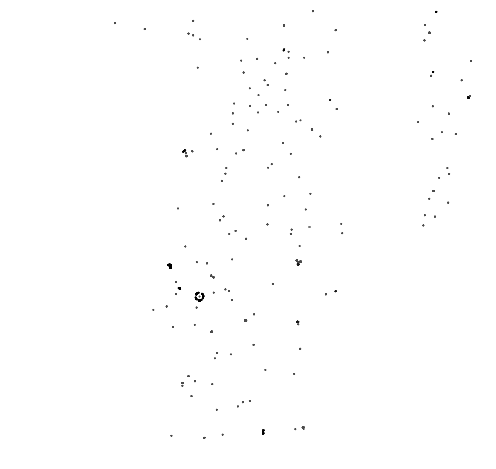

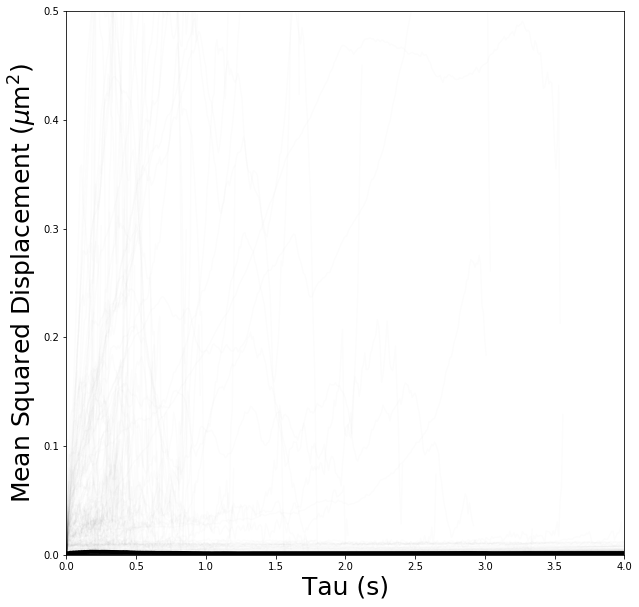

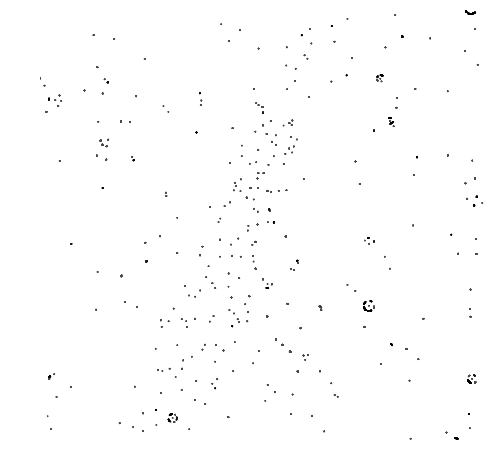

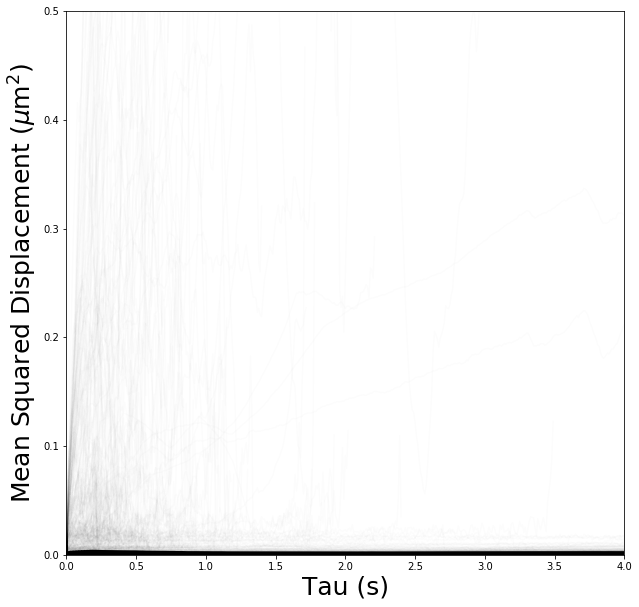

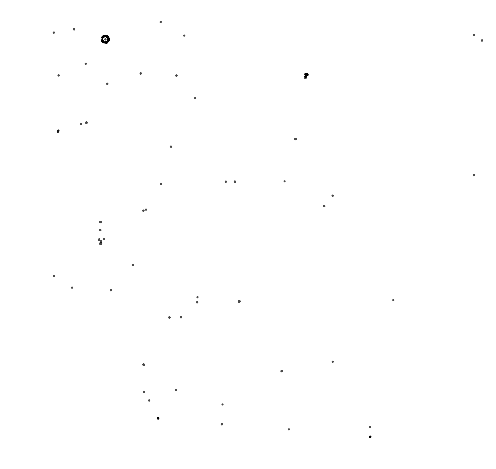

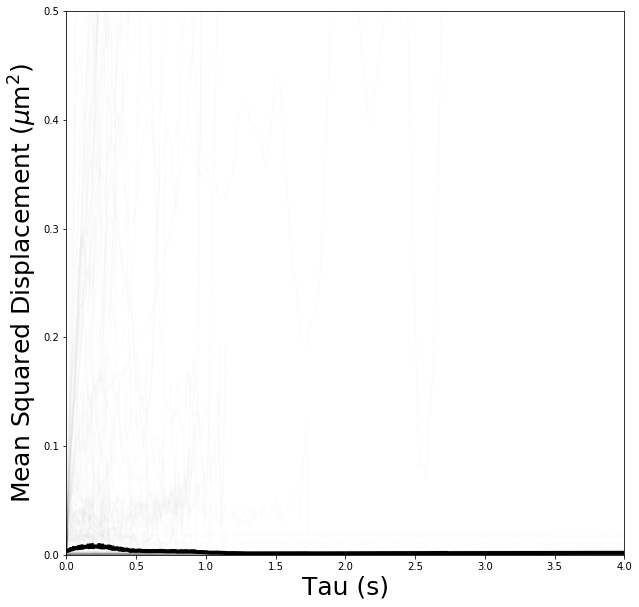

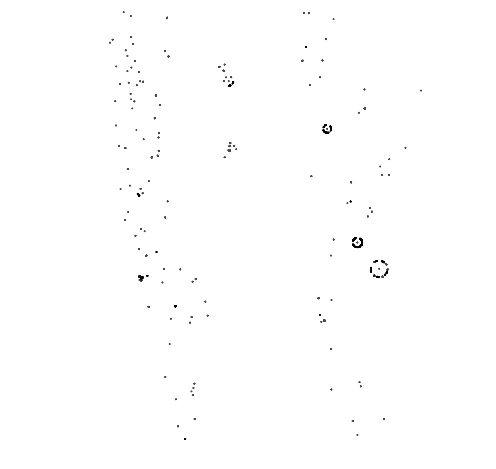

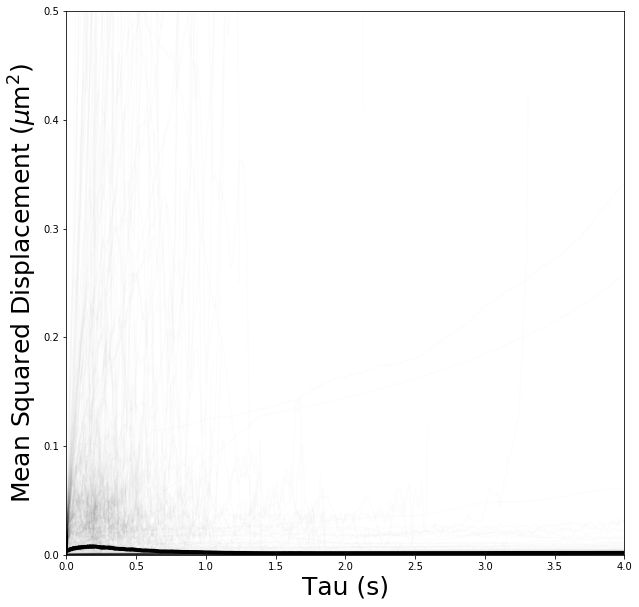

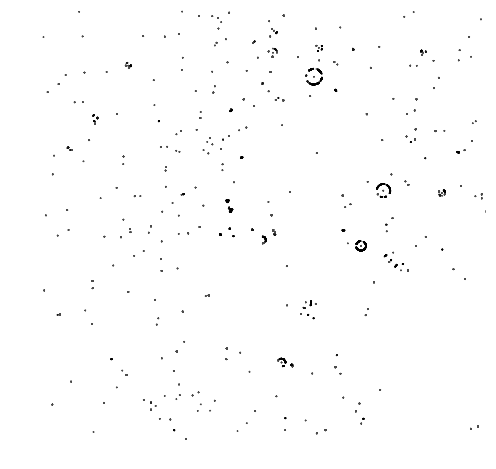

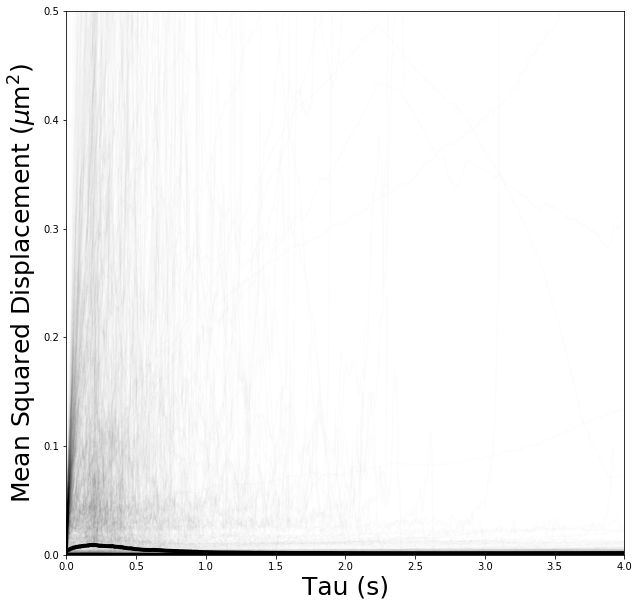

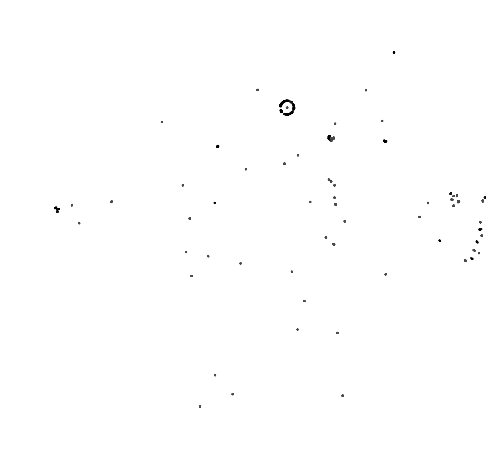

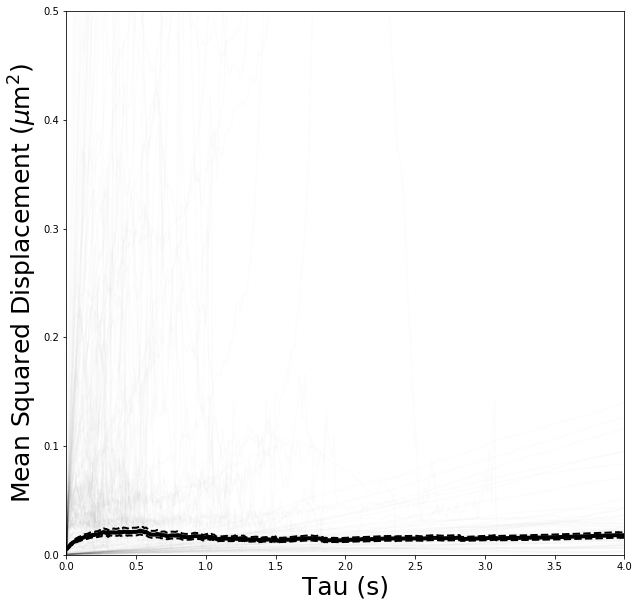

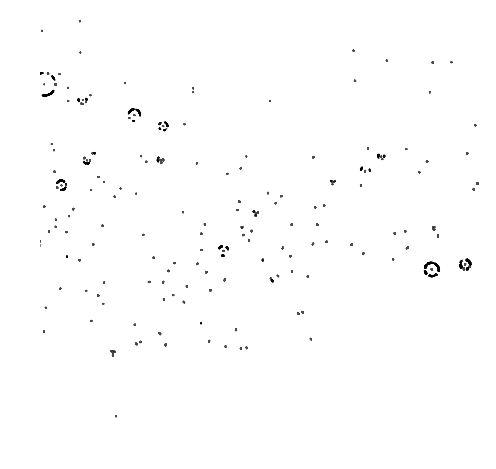

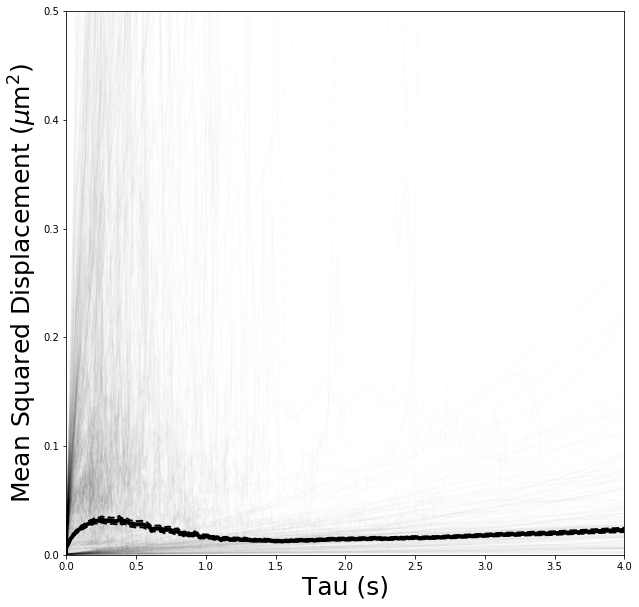

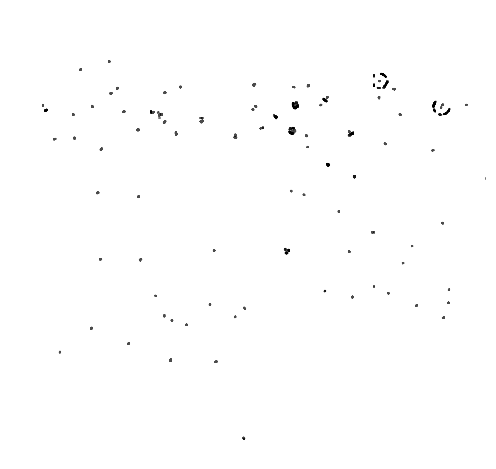

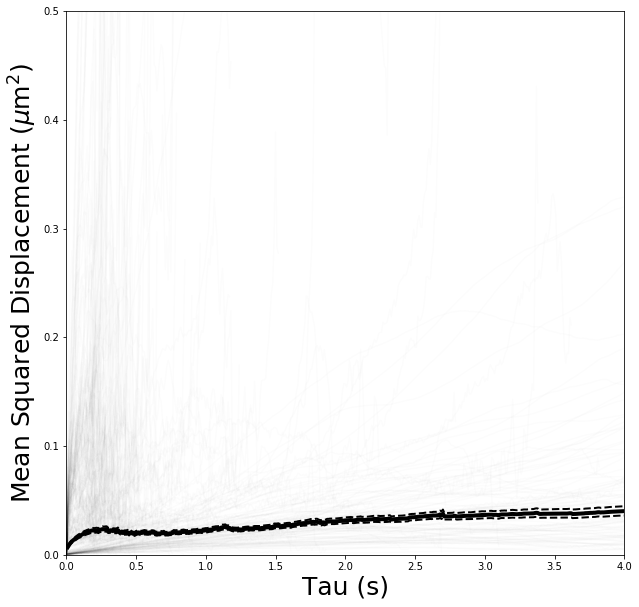

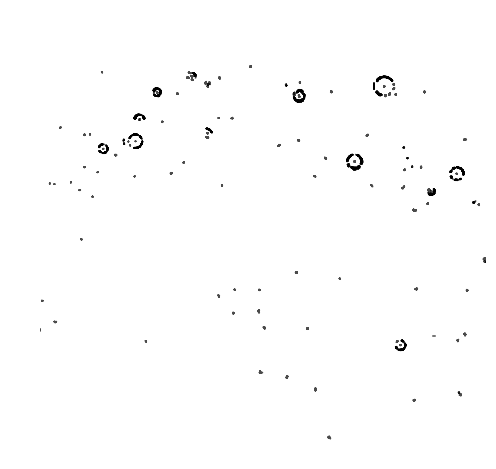

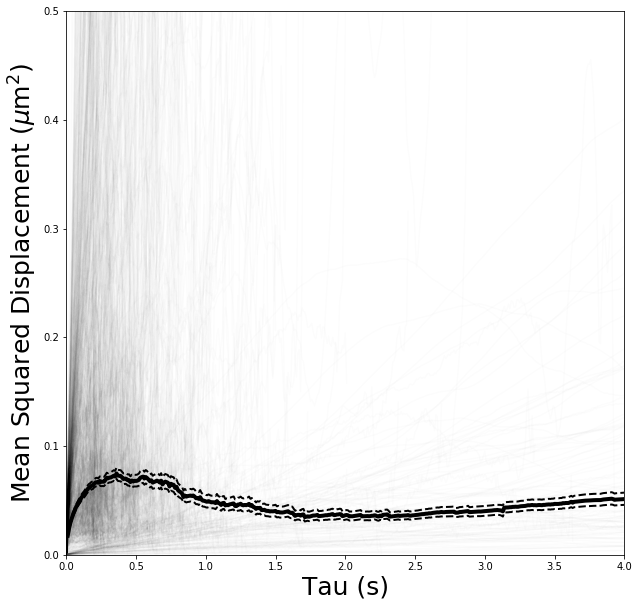

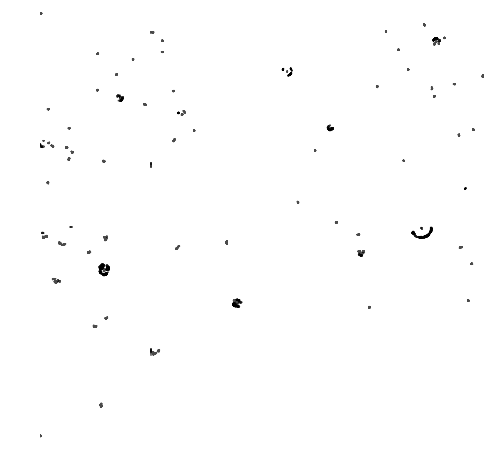

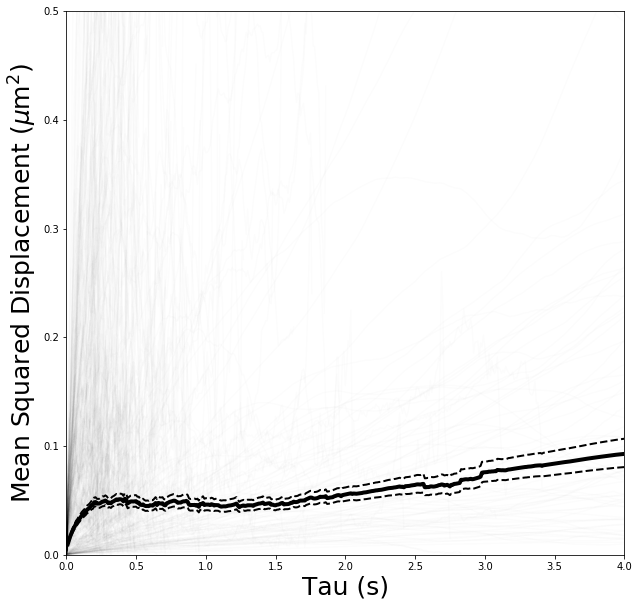

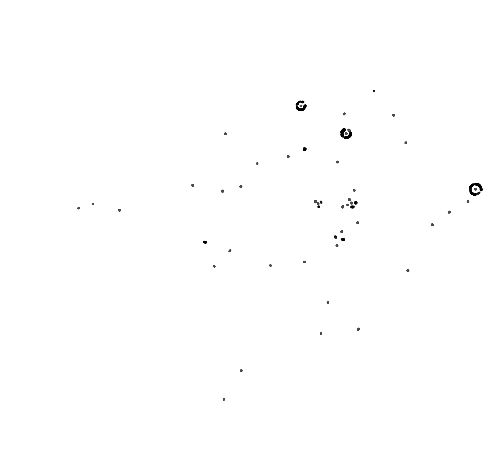

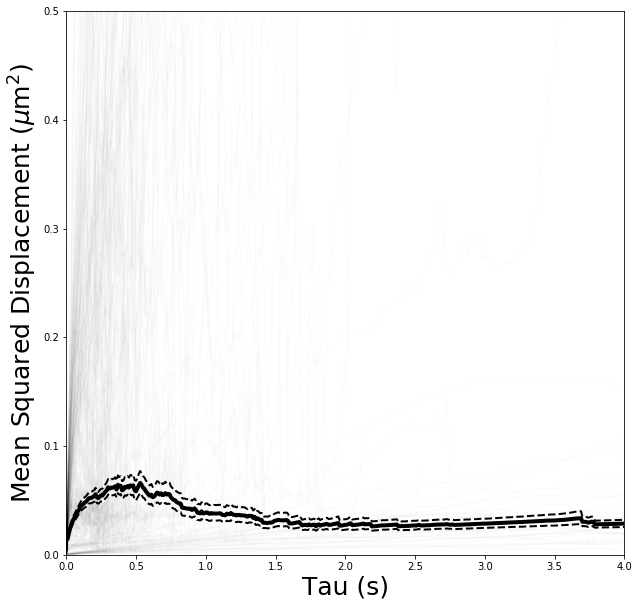

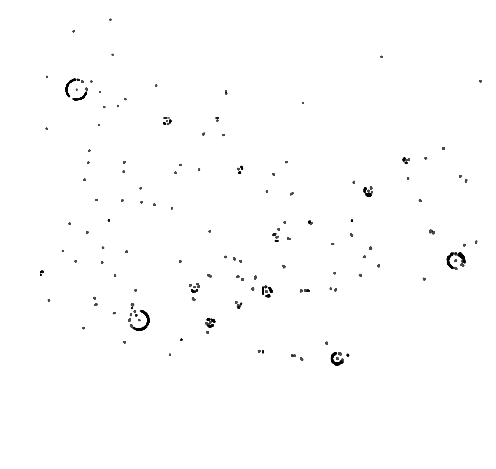

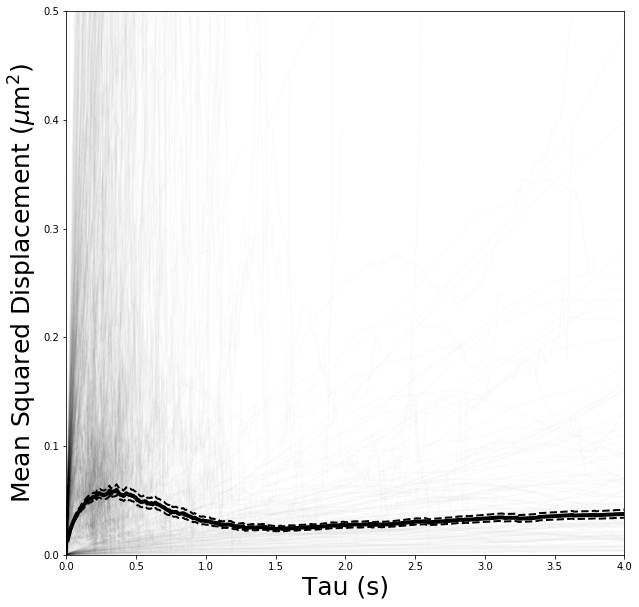

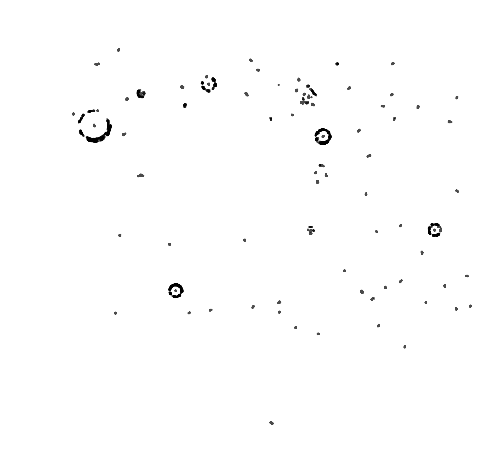

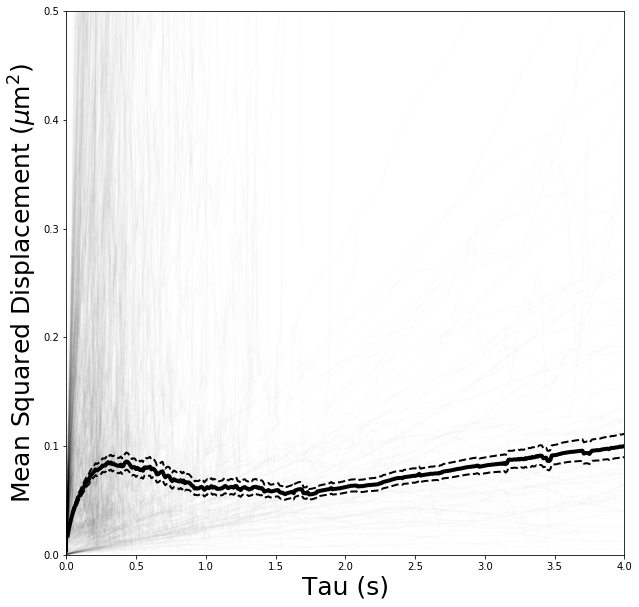

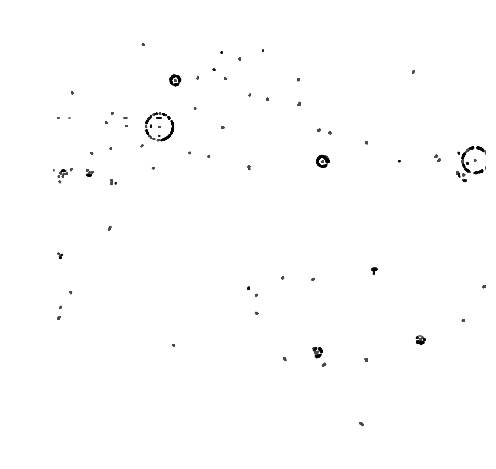

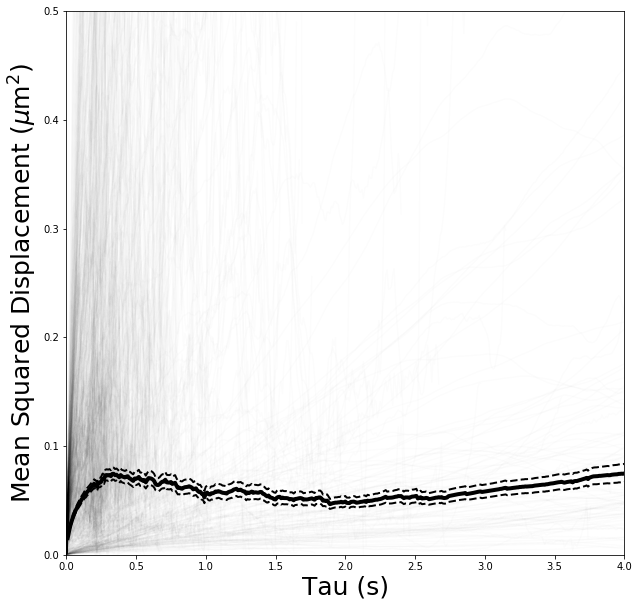

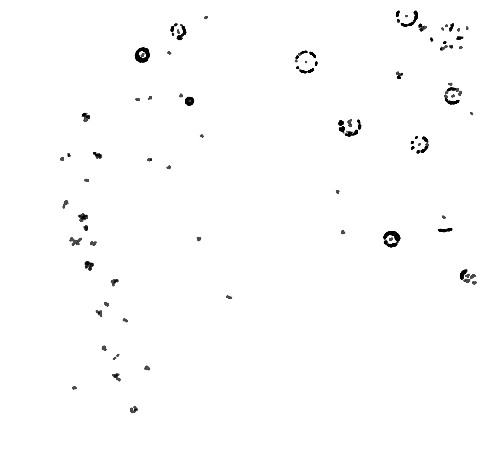

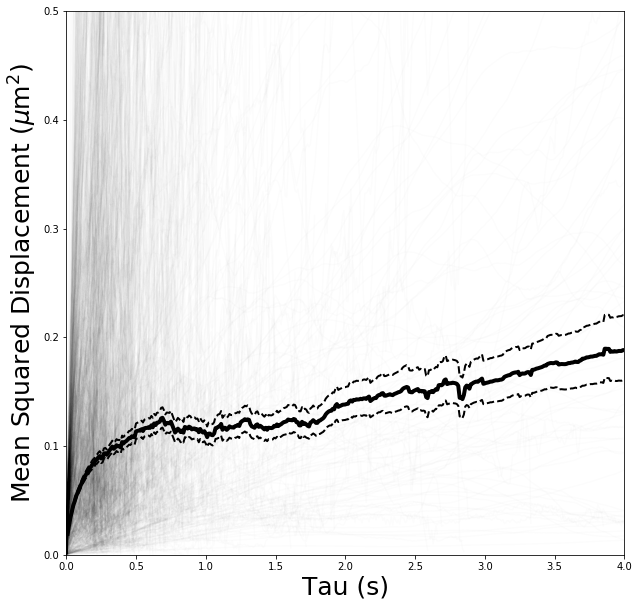

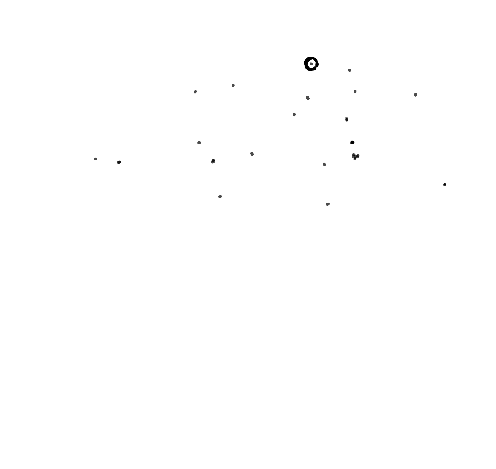

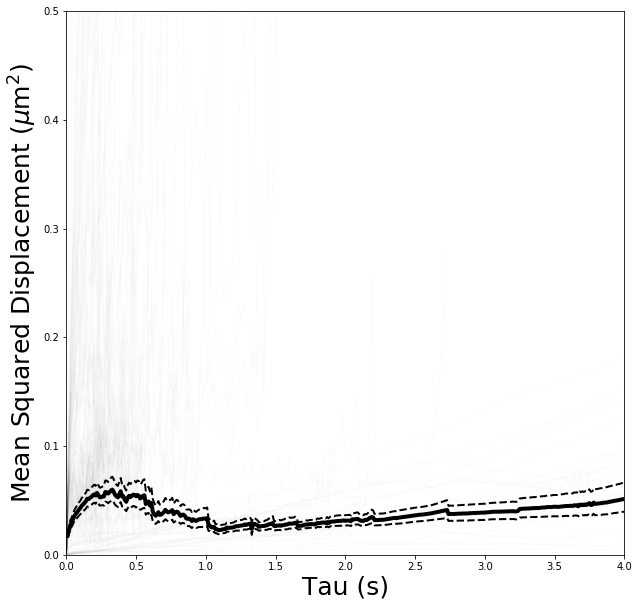

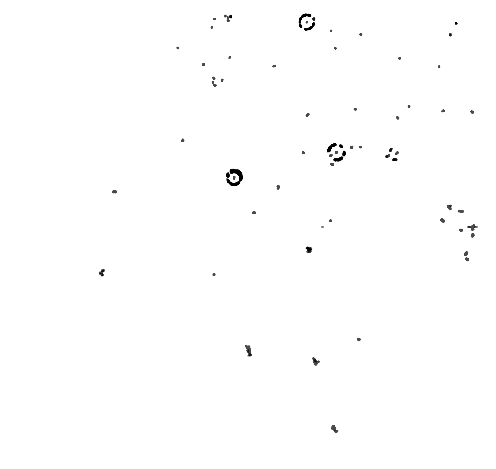

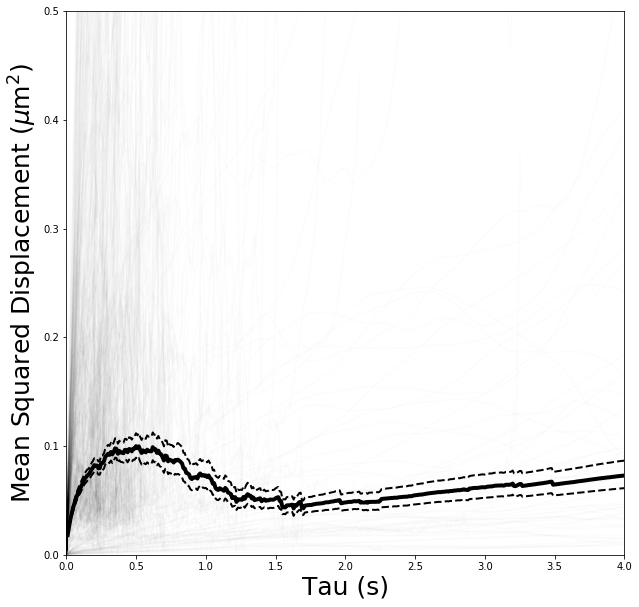

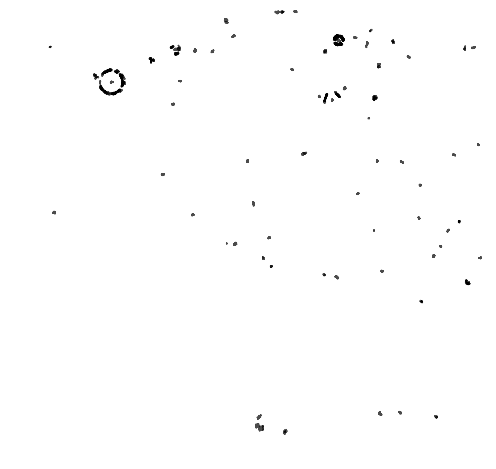

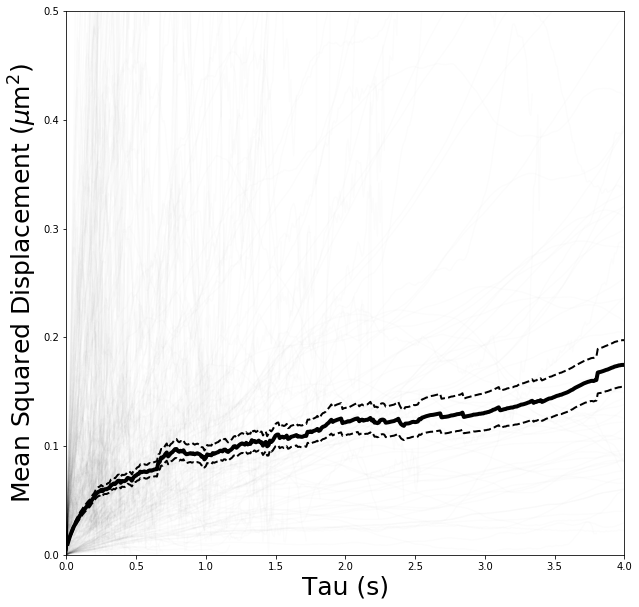

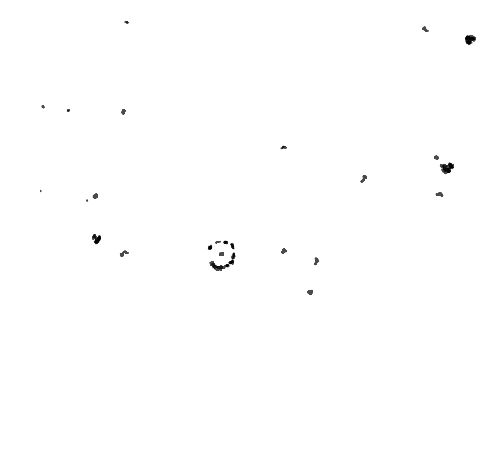

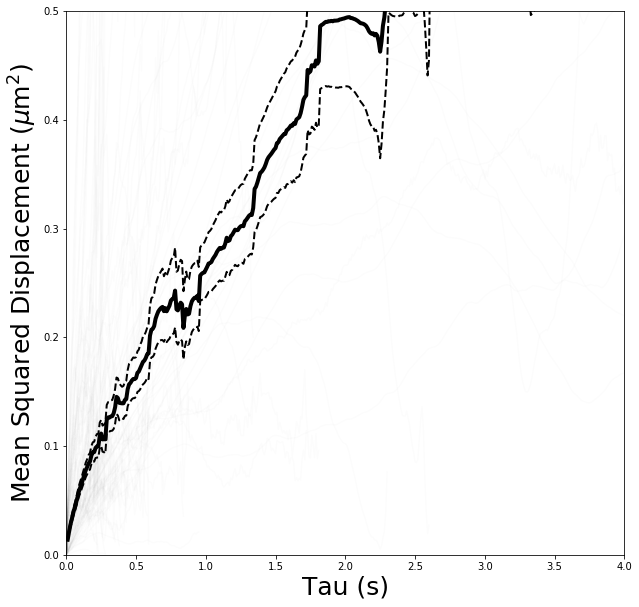

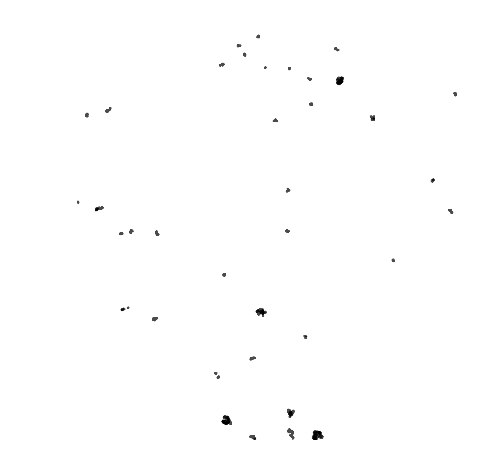

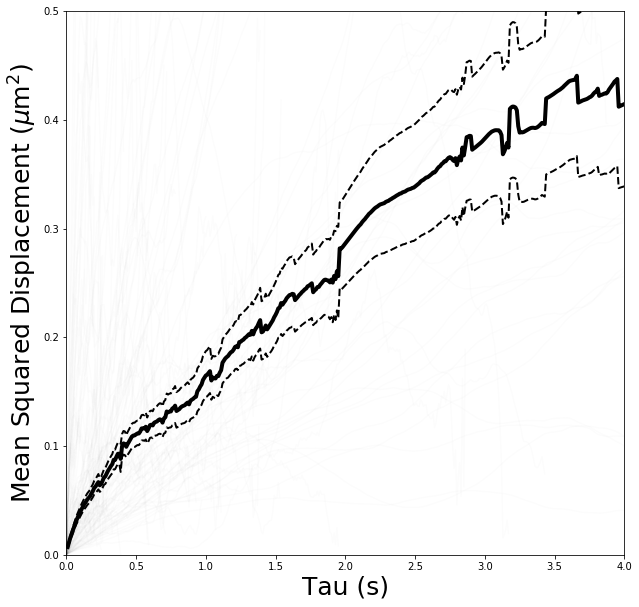

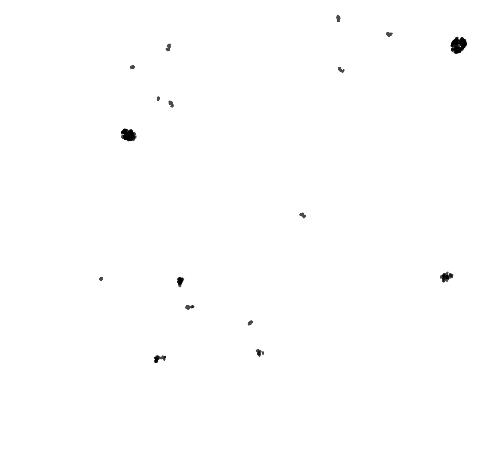

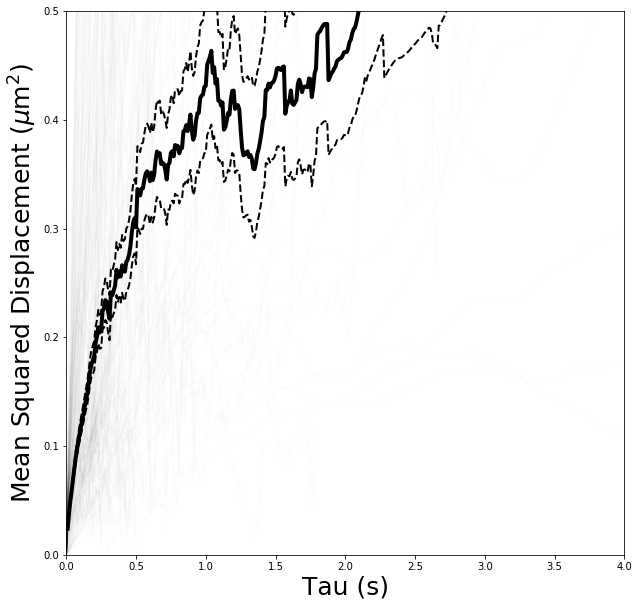

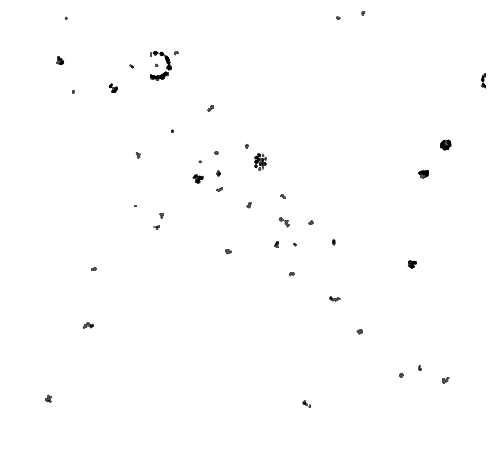

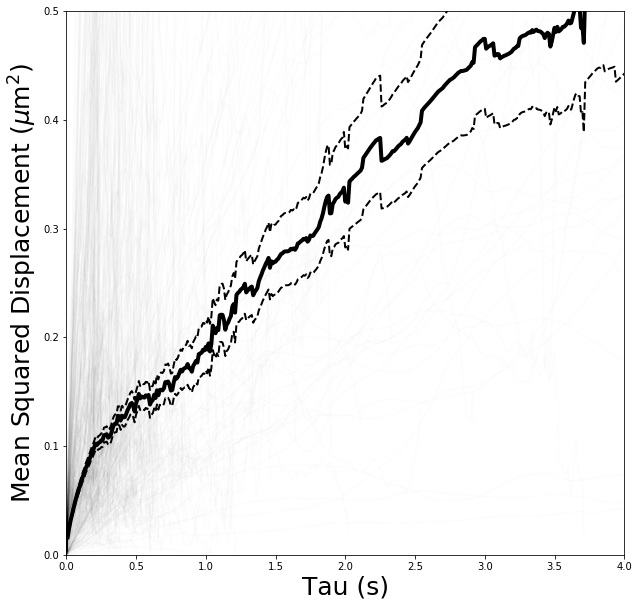

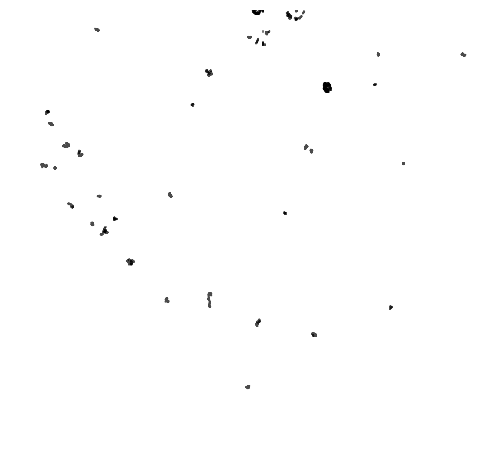

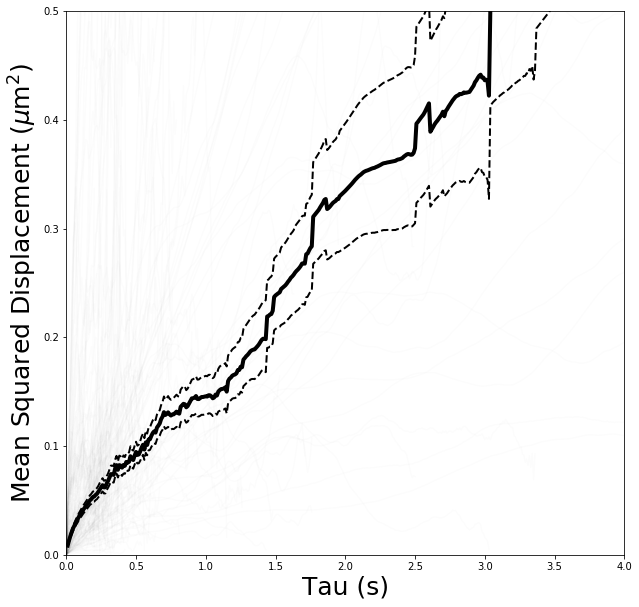

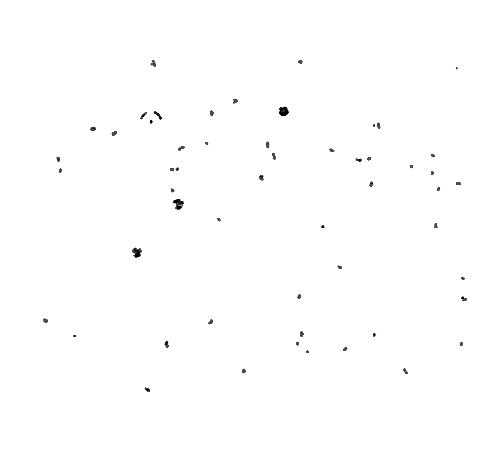

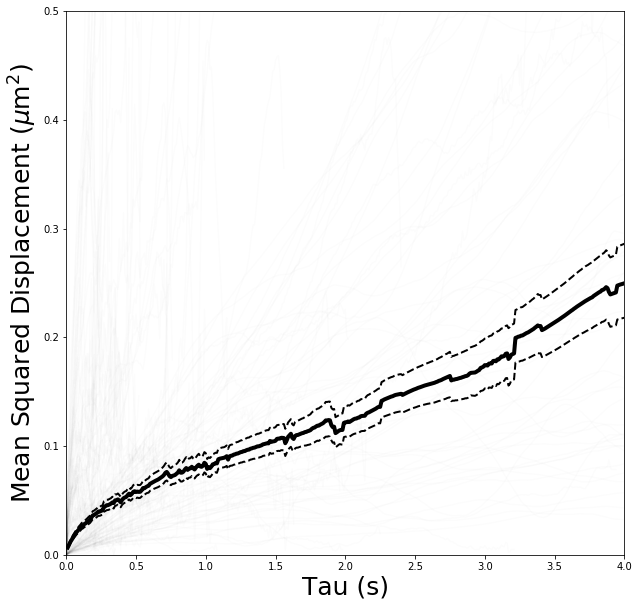

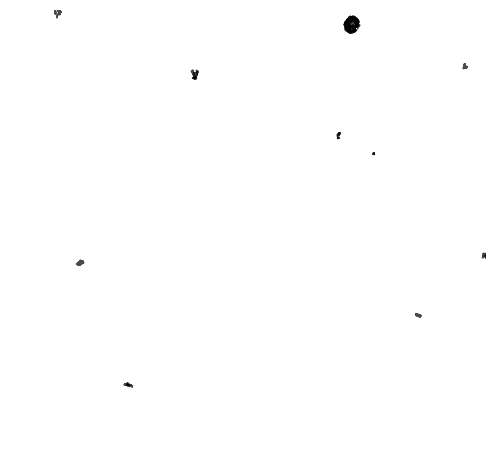

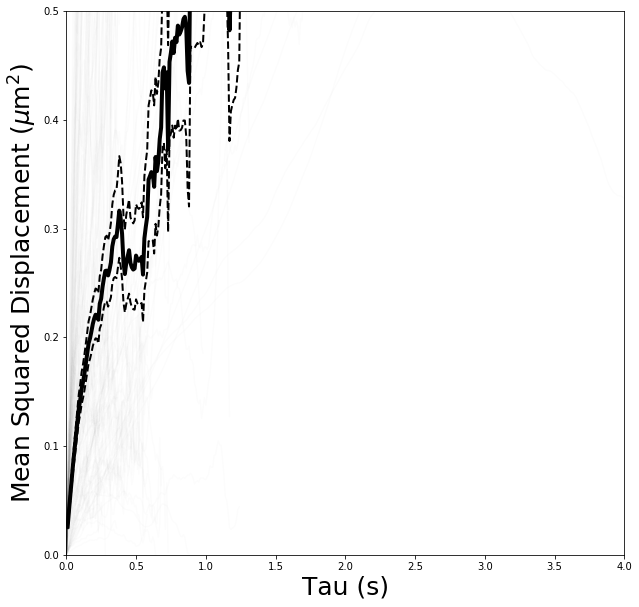

In [4]:
for vids in to_track[25:50]:
    prefix = vids
    msds = 'msd_{}.csv'.format(prefix)
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
    aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)
    hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)
    print('Successfully uploaded trajectory plot for {}'.format(prefix))
    geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=100, upload=True, remote_folder=remote_folder, bucket = bucket)
    aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
    aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
    aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)
    os.remove('features_{}.csv'.format(prefix))
    os.remove('geoSEM_{}.csv'.format(prefix))
    os.remove('msd_{}.csv'.format(prefix))
    os.remove('geomean_{}.csv'.format(prefix))
    print('Successfully uploaded csv files for {}'.format(prefix))
    
    

In [ ]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=100, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [ ]:
hm.plot_heatmap(prefix, upload=False)

In [ ]:
hm.plot_particles_in_frame(prefix, y_range=500, upload=False)

In [ ]:
prefix = to_track[0]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

In [ ]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

In [ ]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=100, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

## Converting msd files

In [5]:
import pandas as pd
import diff_classifier.aws as aws
import math
import os
import os.path as op
from os import listdir

In [6]:
to_track = [] # This is going to be the list of all filenames that will be included in the analysis
start_knot = 80 #Must be unique number for every run on Cloudknot.

remote_folder = '08_01_19_MPT_HYase_treated_HA_trial_2' # The folder in AWS S3 containing the files to be analyzed
bucket = 'mckenna.data' # The bucket in AWS S3 where the remote_folder is contained
NP_size = ['40','100']
vids = 5 # this is the number of vids that were taken per condition (usually corresponding to different locations)
timepoints = ['0', '15', '30', '45', '60']
for sizes in NP_size:
    for tp in timepoints:
        for num in range(1, vids+1):
            to_track.append('HA_{}_t{}_vid{}'.format(sizes, tp, num))

In [8]:
to_track[0:25]

['HA_40_t0_vid1',
 'HA_40_t0_vid2',
 'HA_40_t0_vid3',
 'HA_40_t0_vid4',
 'HA_40_t0_vid5',
 'HA_40_t15_vid1',
 'HA_40_t15_vid2',
 'HA_40_t15_vid3',
 'HA_40_t15_vid4',
 'HA_40_t15_vid5',
 'HA_40_t30_vid1',
 'HA_40_t30_vid2',
 'HA_40_t30_vid3',
 'HA_40_t30_vid4',
 'HA_40_t30_vid5',
 'HA_40_t45_vid1',
 'HA_40_t45_vid2',
 'HA_40_t45_vid3',
 'HA_40_t45_vid4',
 'HA_40_t45_vid5',
 'HA_40_t60_vid1',
 'HA_40_t60_vid2',
 'HA_40_t60_vid3',
 'HA_40_t60_vid4',
 'HA_40_t60_vid5']

In [9]:
import pandas as pd
import diff_classifier.aws as aws
import math

for prefix in to_track:
    filename = 'geomean_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+filename, filename, bucket_name=bucket)
    local_name = filename
    merged = pd.read_csv(local_name)
    merged.columns = ['log']
    merged['exp'] = 0
    for rows in range(0,len(merged)):
        log_value = merged['log'].iloc[rows]
        exp_value = math.exp(log_value)
        merged.loc[rows,'exp'] = exp_value
    merged.to_csv('adj_'+filename, mode='w', index = False)
    aws.upload_s3('./adj_'+filename, remote_folder+'/adj_'+filename, bucket_name = bucket)
    os.remove(filename)
    os.remove('adj_'+filename)

In [ ]:
pref = 'adj_geomean_'

mol_wts = ['high', 'low', 'med']
num_vids = 5

for MW in mol_wts:
    avg_df = pd.DataFrame()
    for vid in range(1, num_vids+1):
        exp = pd.read_csv(pref+'{}MW_40nm_vid_{}.csv'.format(MW, str(vid)))
        avg_df = pd.concat([avg_df, exp['exp']], axis=1)
    avg_df = avg_df.mean(axis = 1)
    avg_df.to_csv('avg_'+pref+'{}MW_40nm.csv'.format(MW), mode='w', index = False)
    aws.upload_s3('./avg_'+pref+'{}MW_40nm.csv'.format(MW), remote_folder+'/avg_'+pref+'{}MW_40nm.csv'.format(MW), bucket_name=bucket)
    

## Generating Histograms

In [7]:
import pandas as pd
import diff_classifier.aws as aws
import math
import os
import os.path as op
from os import listdir

In [ ]:
to_track

## Combined HA Solution Histograms

In [8]:
import pandas as pd
import diff_classifier.aws as aws
import math
import os
import os.path as op
from os import listdir

In [9]:
to_track = [] # This is going to be the list of all filenames that will be included in the analysis
start_knot = 80 #Must be unique number for every run on Cloudknot.

remote_folder = '08_01_19_MPT_HYase_treated_HA_trial_2' # The folder in AWS S3 containing the files to be analyzed
bucket = 'mckenna.data' # The bucket in AWS S3 where the remote_folder is contained
NP_size = ['40','100']
vids = 5 # this is the number of vids that were taken per condition (usually corresponding to different locations)
timepoints = ['0', '15', '30', '45', '60']
for sizes in NP_size:
    for tp in timepoints:
        for num in range(1, vids+1):
            to_track.append('HA_{}_t{}_vid{}'.format(sizes, tp, num))
            
    

In [10]:
import pandas as pd
import diff_classifier.aws as aws
import math

t0_track_40 = to_track[0:5]
t15_track_40 = to_track[5:10]
t30_track_40 = to_track[10:15]
t45_track_40 = to_track[15:20]
t60_track_40 = to_track[20:25]

t0_40 = pd.DataFrame()
t15_40 = pd.DataFrame()
t30_40 = pd.DataFrame()
t45_40 = pd.DataFrame()
t60_40 = pd.DataFrame()

um_px = 0.07
fps_40 = 33
fps_100 = 100

for prefix in t0_track_40:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    t0_40 = pd.concat([t0_40, merged['Deff1']*um_px*um_px*fps_40/10], axis=0)
    os.remove(feat)
t0_40.to_csv('HYase_trial_2_40nm_t0.csv', mode='w', index = False)
    
for prefix in t15_track_40:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    t15_40 = pd.concat([t15_40, merged['Deff1']*um_px*um_px*fps_40/10], axis=0)
    os.remove(feat)
t15_40.to_csv('HYase_trial_2_40nm_t15.csv', mode='w', index = False)
    
for prefix in t30_track_40:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    t30_40 = pd.concat([t30_40, merged['Deff1']*um_px*um_px*fps_40/10], axis=0)
    os.remove(feat)
t30_40.to_csv('HYase_trial_2_40nm_t30.csv', mode='w', index = False)  
    
for prefix in t45_track_40:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    t45_40 = pd.concat([t45_40, merged['Deff1']*um_px*um_px*fps_40/10], axis=0)
    os.remove(feat)
t45_40.to_csv('HYase_trial_2_40nm_t45.csv', mode='w', index = False)  
    
for prefix in t60_track_40:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    t60_40 = pd.concat([t60_40, merged['Deff1']*um_px*um_px*fps_40/10], axis=0)
    os.remove(feat)
t60_40.to_csv('HYase_trial_2_40nm_t60.csv', mode='w', index = False)

In [16]:
import pandas as pd
import diff_classifier.aws as aws
import math

t0_track_100 = to_track[25:30]
t15_track_100 = to_track[30:35]
t30_track_100 = to_track[35:40]
t45_track_100 = to_track[40:45]
t60_track_100 = to_track[45:50]

t0_100 = pd.DataFrame()
t15_100 = pd.DataFrame()
t30_100 = pd.DataFrame()
t45_100 = pd.DataFrame()
t60_100 = pd.DataFrame()

um_px = 0.07
fps_40 = 33
fps_100 = 100

for prefix in t0_track_100:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    t0_100 = pd.concat([t0_100, merged['Deff1']*um_px*um_px*fps_100/10], axis=0)
    os.remove(feat)
t0_100.to_csv('HYase_trial_2_100nm_t0.csv', mode='w', index = False)
    
for prefix in t15_track_100:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    t15_100 = pd.concat([t15_100, merged['Deff1']*um_px*um_px*fps_100/10], axis=0)
    os.remove(feat)
t15_100.to_csv('HYase_trial_2_100nm_t15.csv', mode='w', index = False)
    
for prefix in t30_track_100:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    t30_100 = pd.concat([t30_100, merged['Deff1']*um_px*um_px*fps_100/10], axis=0)
    os.remove(feat)
t30_100.to_csv('HYase_trial_2_100nm_t30.csv', mode='w', index = False)  
    
for prefix in t45_track_100:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    t45_100 = pd.concat([t45_100, merged['Deff1']*um_px*um_px*fps_100/10], axis=0)
    os.remove(feat)
t45_100.to_csv('HYase_trial_2_100nm_t45.csv', mode='w', index = False)  
    
for prefix in t60_track_100:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    t60_100 = pd.concat([t60_100, merged['Deff1']*um_px*um_px*fps_100/10], axis=0)
    os.remove(feat)
t60_100.to_csv('HYase_trial_2_100nm_t60.csv', mode='w', index = False)

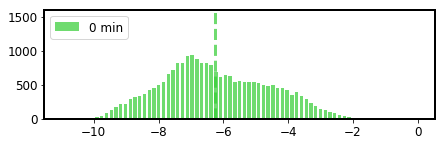

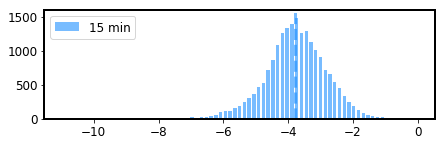

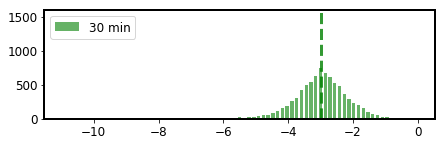

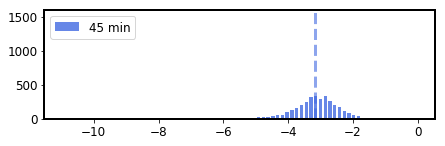

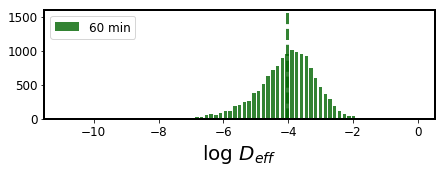

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

t0_40nm_2 = pd.read_csv('HYase_trial_2_40nm_t0.csv')
t15_40nm_2 = pd.read_csv('HYase_trial_2_40nm_t15.csv')
t30_40nm_2 = pd.read_csv('HYase_trial_2_40nm_t30.csv')
t45_40nm_2 = pd.read_csv('HYase_trial_2_40nm_t45.csv')
t60_40nm_2 = pd.read_csv('HYase_trial_2_40nm_t60.csv')

t0_40nm_2_no_nan = t0_40nm_2.replace(0,np.nan)
t15_40nm_2_no_nan = t15_40nm_2.replace(0,np.nan)
t30_40nm_2_no_nan = t30_40nm_2.replace(0,np.nan)
t45_40nm_2_no_nan = t45_40nm_2.replace(0,np.nan)
t60_40nm_2_no_nan = t60_40nm_2.replace(0,np.nan)


log_Deff_t0_40 = np.log(t0_40nm_2_no_nan.dropna())
log_Deff_t15_40 = np.log(t15_40nm_2_no_nan.dropna())
log_Deff_t30_40 = np.log(t30_40nm_2_no_nan.dropna())
log_Deff_t45_40 = np.log(t45_40nm_2_no_nan.dropna())
log_Deff_t60_40 = np.log(t60_40nm_2_no_nan.dropna())

test_bins = np.linspace(-11, 0, 76)

t0_hist_40, t0_bins_40 = np.histogram(log_Deff_t0_40, bins=test_bins)
t15_hist_40, t15_bins_40 = np.histogram(log_Deff_t15_40, bins=test_bins)
t30_hist_40, t30_bins_40 = np.histogram(log_Deff_t30_40, bins=test_bins)
t45_hist_40, t45_bins_40 = np.histogram(log_Deff_t45_40, bins=test_bins)
t60_hist_40, t60_bins_40 = np.histogram(log_Deff_t60_40, bins=test_bins)

t0_avg_40 = np.mean(log_Deff_t0_40)[0]
t15_avg_40 = np.mean(log_Deff_t15_40)[0]
t30_avg_40 = np.mean(log_Deff_t30_40)[0]
t45_avg_40 = np.mean(log_Deff_t45_40)[0]
t60_avg_40 = np.mean(log_Deff_t60_40)[0]

plt.rc('axes', linewidth=2)
t0_plot_40, t15_plot_40, t30_plot_40 = t0_hist_40, t15_hist_40, t30_hist_40
t45_plot_40, t60_plot_40 = t45_hist_40, t60_hist_40

bins = test_bins
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:])/2

plt.figure(711, figsize=(7,2)).tight_layout()
plt.bar(center, t0_plot_40, color='limegreen', align='center', width=width, alpha=0.7, label='0 min')
plt.axvline(t0_avg_40, color='limegreen', linestyle='--', alpha=0.7, linewidth=3)
plt.ylim((0,1600))
#plt.xlabel('log $D_{eff}$', fontsize=20)
#plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize='large', loc=2)

plt.figure(712, figsize=(7,2)).tight_layout()
plt.bar(center, t15_plot_40, color='dodgerblue', align='center', width=width, alpha=0.6, label='15 min')
plt.axvline(t15_avg_40, color='dodgerblue', linestyle='--', alpha=0.6, linewidth=3)
plt.ylim((0,1600))
#plt.xlabel('log $D_{eff}$', fontsize=20)
#plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize='large', loc=2)

plt.figure(713, figsize=(7,2)).tight_layout()
plt.bar(center, t30_plot_40, color='green',  align='center', width=width, alpha=0.6, label='30 min')
plt.axvline(t30_avg_40, color='green', linestyle='--', alpha=0.8, linewidth=3)
plt.ylim((0,1600))
#plt.xlabel('log $D_{eff}$', fontsize=20)
#plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize='large', loc=2)

plt.figure(714, figsize=(7,2)).tight_layout()
plt.bar(center, t45_plot_40, color='royalblue',  align='center', width=width, alpha=0.8, label='45 min')
plt.axvline(t45_avg_40, color='royalblue', linestyle='--', alpha=0.6, linewidth=3)
plt.ylim((0,1600))
#plt.xlabel('log $D_{eff}$', fontsize=20)
#plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize='large', loc=2)

plt.figure(715, figsize=(7,2)).tight_layout()
plt.bar(center, t60_plot_40, color='darkgreen',  align='center', width=width, alpha=0.8, label='60 min')
plt.axvline(t60_avg_40, color='darkgreen', linestyle='--', alpha=0.8, linewidth=3)
plt.ylim((0,1600))
plt.xlabel('log $D_{eff}$', fontsize=20)
#plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize='large', loc=2)

plt.show()

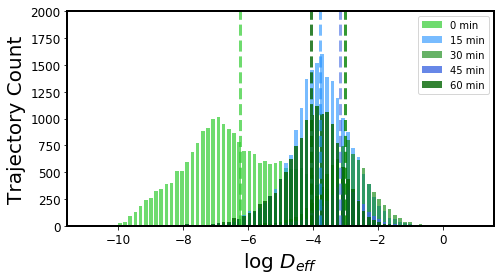

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

t0_40nm_2 = pd.read_csv('HYase_trial_2_40nm_t0.csv')
t15_40nm_2 = pd.read_csv('HYase_trial_2_40nm_t15.csv')
t30_40nm_2 = pd.read_csv('HYase_trial_2_40nm_t30.csv')
t45_40nm_2 = pd.read_csv('HYase_trial_2_40nm_t45.csv')
t60_40nm_2 = pd.read_csv('HYase_trial_2_40nm_t60.csv')

t0_40nm_2_no_nan = t0_40nm_2.replace(0,np.nan)
t15_40nm_2_no_nan = t15_40nm_2.replace(0,np.nan)
t30_40nm_2_no_nan = t30_40nm_2.replace(0,np.nan)
t45_40nm_2_no_nan = t45_40nm_2.replace(0,np.nan)
t60_40nm_2_no_nan = t60_40nm_2.replace(0,np.nan)


log_Deff_t0_40 = np.log(t0_40nm_2_no_nan.dropna())
log_Deff_t15_40 = np.log(t15_40nm_2_no_nan.dropna())
log_Deff_t30_40 = np.log(t30_40nm_2_no_nan.dropna())
log_Deff_t45_40 = np.log(t45_40nm_2_no_nan.dropna())
log_Deff_t60_40 = np.log(t60_40nm_2_no_nan.dropna())

test_bins = np.linspace(-11, 1, 76)

t0_hist_40, t0_bins_40 = np.histogram(log_Deff_t0_40, bins=test_bins)
t15_hist_40, t15_bins_40 = np.histogram(log_Deff_t15_40, bins=test_bins)
t30_hist_40, t30_bins_40 = np.histogram(log_Deff_t30_40, bins=test_bins)
t45_hist_40, t45_bins_40 = np.histogram(log_Deff_t45_40, bins=test_bins)
t60_hist_40, t60_bins_40 = np.histogram(log_Deff_t60_40, bins=test_bins)

t0_avg_40 = np.mean(log_Deff_t0_40)[0]
t15_avg_40 = np.mean(log_Deff_t15_40)[0]
t30_avg_40 = np.mean(log_Deff_t30_40)[0]
t45_avg_40 = np.mean(log_Deff_t45_40)[0]
t60_avg_40 = np.mean(log_Deff_t60_40)[0]

plt.rc('axes', linewidth=2)
t0_plot_40, t15_plot_40, t30_plot_40 = t0_hist_40, t15_hist_40, t30_hist_40
t45_plot_40, t60_plot_40 = t45_hist_40, t60_hist_40

bins = test_bins
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:])/2

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, t0_plot_40, color='limegreen', align='center', width=width, alpha=0.7, label='0 min')
plt.axvline(t0_avg_40, color='limegreen', linestyle='--', alpha=0.7, linewidth=3)
plt.ylim((0,800))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, t15_plot_40, color='dodgerblue', align='center', width=width, alpha=0.6, label='15 min')
plt.axvline(t15_avg_40, color='dodgerblue', linestyle='--', alpha=0.6, linewidth=3)
plt.ylim((0,400))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, t30_plot_40, color='green',  align='center', width=width, alpha=0.6, label='30 min')
plt.axvline(t30_avg_40, color='green', linestyle='--', alpha=0.8, linewidth=3)
plt.ylim((0,100))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, t45_plot_40, color='royalblue',  align='center', width=width, alpha=0.8, label='45 min')
plt.axvline(t45_avg_40, color='royalblue', linestyle='--', alpha=0.6, linewidth=3)
plt.ylim((0,100))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, t60_plot_40, color='darkgreen',  align='center', width=width, alpha=0.8, label='60 min')
plt.axvline(t60_avg_40, color='darkgreen', linestyle='--', alpha=0.8, linewidth=3)
plt.ylim((0,100))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.ylim((0,2000))
plt.legend()
plt.show()

In [19]:
print(t0_avg_40, t15_avg_40, t30_avg_40, t45_avg_40, t60_avg_40)
print(np.exp(t0_avg_40), np.exp(t15_avg_40), np.exp(t30_avg_40), np.exp(t45_avg_40), np.exp(t60_avg_40))

-6.2506030096 -3.77725894895 -3.00245828311 -3.17508925046 -4.05360519494
0.00192929040477 0.0228853354034 0.049664827971 0.0417903741082 0.0173596766697


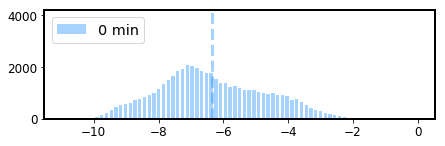

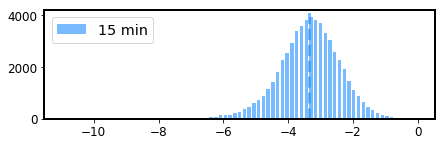

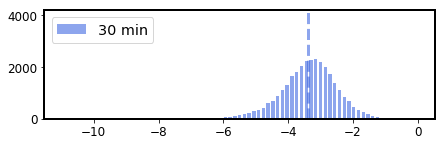

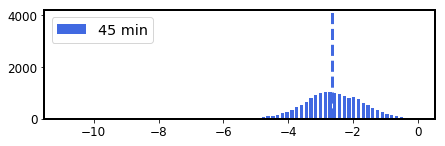

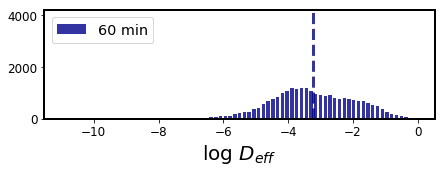

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

t0_40nm_1 = pd.read_csv('HYase_trial_1_40nm_t0.csv')
t15_40nm_1 = pd.read_csv('HYase_trial_1_40nm_t15.csv')
t30_40nm_1 = pd.read_csv('HYase_trial_1_40nm_t30.csv')
t45_40nm_1 = pd.read_csv('HYase_trial_1_40nm_t45.csv')
t60_40nm_1 = pd.read_csv('HYase_trial_1_40nm_t60.csv')
t0_40nm_2 = pd.read_csv('HYase_trial_2_40nm_t0.csv')
t15_40nm_2 = pd.read_csv('HYase_trial_2_40nm_t15.csv')
t30_40nm_2 = pd.read_csv('HYase_trial_2_40nm_t30.csv')
t45_40nm_2 = pd.read_csv('HYase_trial_2_40nm_t45.csv')
t60_40nm_2 = pd.read_csv('HYase_trial_2_40nm_t60.csv')

t0_combined = pd.DataFrame()
t15_combined = pd.DataFrame()
t30_combined = pd.DataFrame()
t45_combined = pd.DataFrame()
t60_combined = pd.DataFrame()

t0_combined = pd.concat([t0_40nm_1, t0_40nm_2], axis=0)
t15_combined = pd.concat([t15_40nm_1, t15_40nm_2], axis=0)
t30_combined = pd.concat([t30_40nm_1, t30_40nm_2], axis=0)
t45_combined = pd.concat([t45_40nm_1, t45_40nm_2], axis=0)
t60_combined = pd.concat([t60_40nm_1, t60_40nm_2], axis=0)

t0_combined_no_nan = t0_combined.replace(0,np.nan)
t15_combined_no_nan = t15_combined.replace(0,np.nan)
t30_combined_no_nan = t30_combined.replace(0,np.nan)
t45_combined_no_nan = t45_combined.replace(0,np.nan)
t60_combined_no_nan = t60_combined.replace(0,np.nan)

log_Deff_t0_combined = np.log(t0_combined_no_nan.dropna())
log_Deff_t15_combined = np.log(t15_combined_no_nan.dropna())
log_Deff_t30_combined = np.log(t30_combined_no_nan.dropna())
log_Deff_t45_combined = np.log(t45_combined_no_nan.dropna())
log_Deff_t60_combined = np.log(t60_combined_no_nan.dropna())

test_bins = np.linspace(-11, 0, 76)

t0_hist_combined, t0_bins_combined = np.histogram(log_Deff_t0_combined, bins=test_bins)
t15_hist_combined, t15_bins_combined = np.histogram(log_Deff_t15_combined, bins=test_bins)
t30_hist_combined, t30_bins_combined = np.histogram(log_Deff_t30_combined, bins=test_bins)
t45_hist_combined, t45_bins_combined = np.histogram(log_Deff_t45_combined, bins=test_bins)
t60_hist_combined, t60_bins_combined = np.histogram(log_Deff_t60_combined, bins=test_bins)

t0_avg_combined = np.mean(log_Deff_t0_combined)[0]
t15_avg_combined = np.mean(log_Deff_t15_combined)[0]
t30_avg_combined = np.mean(log_Deff_t30_combined)[0]
t45_avg_combined = np.mean(log_Deff_t45_combined)[0]
t60_avg_combined = np.mean(log_Deff_t60_combined)[0]

plt.rc('axes', linewidth=2)
t0_plot_combined, t15_plot_combined, t30_plot_combined = t0_hist_combined, t15_hist_combined, t30_hist_combined
t45_plot_combined, t60_plot_combined = t45_hist_combined, t60_hist_combined

bins = test_bins
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:])/2

plt.figure(711, figsize=(7,2)).tight_layout()
plt.bar(center, t0_plot_combined, color='dodgerblue', align='center', width=width, alpha=0.4, label='0 min')
plt.axvline(t0_avg_combined, color='dodgerblue', linestyle='--', alpha=0.4, linewidth=3)
plt.ylim((0,4200))
#plt.xlabel('log $D_{eff}$', fontsize=20)
#plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize='x-large', loc=2)

plt.figure(712, figsize=(7,2)).tight_layout()
plt.bar(center, t15_plot_combined, color='dodgerblue', align='center', width=width, alpha=0.6, label='15 min')
plt.axvline(t15_avg_combined, color='dodgerblue', linestyle='--', alpha=0.6, linewidth=3)
plt.ylim((0,4200))
#plt.xlabel('log $D_{eff}$', fontsize=20)
#plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize='x-large', loc=2)

plt.figure(713, figsize=(7,2)).tight_layout()
plt.bar(center, t30_plot_combined, color='royalblue',  align='center', width=width, alpha=0.6, label='30 min')
plt.axvline(t30_avg_combined, color='royalblue', linestyle='--', alpha=0.6, linewidth=3)
plt.ylim((0,4200))
#plt.xlabel('log $D_{eff}$', fontsize=20)
#plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize='x-large', loc=2)

plt.figure(714, figsize=(7,2)).tight_layout()
plt.bar(center, t45_plot_combined, color='royalblue',  align='center', width=width, alpha=1, label='45 min')
plt.axvline(t45_avg_combined, color='royalblue', linestyle='--', alpha=1, linewidth=3)
plt.ylim((0,4200))
#plt.xlabel('log $D_{eff}$', fontsize=20)
#plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize='x-large', loc=2)

plt.figure(715, figsize=(7,2)).tight_layout()
plt.bar(center, t60_plot_combined, color='darkblue',  align='center', width=width, alpha=0.8, label='60 min')
plt.axvline(t60_avg_combined, color='darkblue', linestyle='--', alpha=0.8, linewidth=3)
plt.ylim((0,4200))
plt.xlabel('log $D_{eff}$', fontsize=20)
#plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize='x-large', loc=2)

plt.show()

In [26]:
print(t0_avg_combined, t15_avg_combined, t30_avg_combined, t45_avg_combined, t60_avg_combined)
print(np.exp(t0_avg_combined), np.exp(t15_avg_combined), np.exp(t30_avg_combined), np.exp(t45_avg_combined), np.exp(t60_avg_combined))

-6.34971248926 -3.3660020621 -3.37723905233 -2.65171749966 -3.24836584786
0.00174724941703 0.0345274001781 0.034141587864 0.0705299737698 0.0388376225871


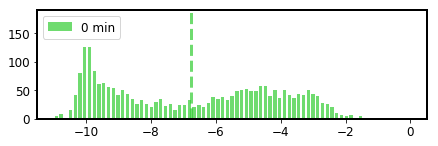

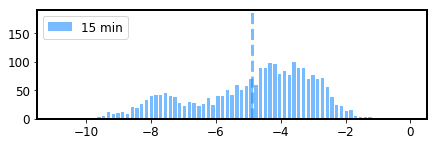

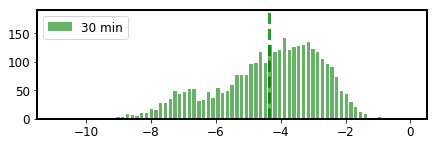

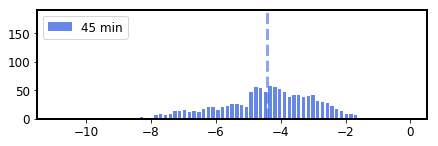

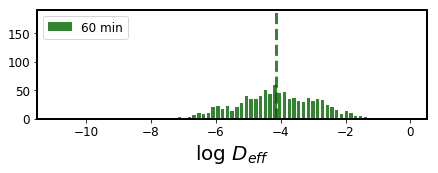

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

np_size = '100'

t0_100nm_2 = pd.read_csv('HYase_trial_2_{}nm_t0.csv'.format(np_size))
t15_100nm_2 = pd.read_csv('HYase_trial_2_{}nm_t15.csv'.format(np_size))
t30_100nm_2 = pd.read_csv('HYase_trial_2_{}nm_t30.csv'.format(np_size))
t45_100nm_2 = pd.read_csv('HYase_trial_2_{}nm_t45.csv'.format(np_size))
t60_100nm_2 = pd.read_csv('HYase_trial_2_{}nm_t60.csv'.format(np_size))

t0_100nm_2_no_nan = t0_100nm_2.replace(0,np.nan)
t15_100nm_2_no_nan = t15_100nm_2.replace(0,np.nan)
t30_100nm_2_no_nan = t30_100nm_2.replace(0,np.nan)
t45_100nm_2_no_nan = t45_100nm_2.replace(0,np.nan)
t60_100nm_2_no_nan = t60_100nm_2.replace(0,np.nan)

log_Deff_t0_100 = np.log(t0_100nm_2_no_nan.dropna())
log_Deff_t15_100 = np.log(t15_100nm_2_no_nan.dropna())
log_Deff_t30_100 = np.log(t30_100nm_2_no_nan.dropna())
log_Deff_t45_100 = np.log(t45_100nm_2_no_nan.dropna())
log_Deff_t60_100 = np.log(t60_100nm_2_no_nan.dropna())

test_bins = np.linspace(-11, 0, 76)

t0_hist_100, t0_bins_100 = np.histogram(log_Deff_t0_100, bins=test_bins)
t15_hist_100, t15_bins_100 = np.histogram(log_Deff_t15_100, bins=test_bins)
t30_hist_100, t30_bins_100 = np.histogram(log_Deff_t30_100, bins=test_bins)
t45_hist_100, t45_bins_100 = np.histogram(log_Deff_t45_100, bins=test_bins)
t60_hist_100, t60_bins_100 = np.histogram(log_Deff_t60_100, bins=test_bins)

t0_avg_100 = np.mean(log_Deff_t0_100)[0]
t15_avg_100 = np.mean(log_Deff_t15_100)[0]
t30_avg_100 = np.mean(log_Deff_t30_100)[0]
t45_avg_100 = np.mean(log_Deff_t45_100)[0]
t60_avg_100 = np.mean(log_Deff_t60_100)[0]

plt.rc('axes', linewidth=2)
t0_plot_100, t15_plot_100, t30_plot_100 = t0_hist_100, t15_hist_100, t30_hist_100
t45_plot_100, t60_plot_100 = t45_hist_100, t60_hist_100

bins = test_bins
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:])/2

plt.figure(711, figsize=(7,2)).tight_layout()
plt.bar(center, t0_plot_100, color='limegreen', align='center', width=width, alpha=0.7, label='0 min')
plt.axvline(t0_avg_100, color='limegreen', linestyle='--', alpha=0.7, linewidth=3)
plt.ylim((0,190))
#plt.xlabel('log $D_{eff}$', fontsize=20)
#plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize='large', loc=2)

plt.figure(712, figsize=(7,2)).tight_layout()
plt.bar(center, t15_plot_100, color='dodgerblue', align='center', width=width, alpha=0.6, label='15 min')
plt.axvline(t15_avg_100, color='dodgerblue', linestyle='--', alpha=0.6, linewidth=3)
plt.ylim((0,190))
#plt.xlabel('log $D_{eff}$', fontsize=20)
#plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize='large', loc=2)

plt.figure(713, figsize=(7,2)).tight_layout()
plt.bar(center, t30_plot_100, color='green',  align='center', width=width, alpha=0.6, label='30 min')
plt.axvline(t30_avg_100, color='green', linestyle='--', alpha=0.8, linewidth=3)
plt.ylim((0,190))
#plt.xlabel('log $D_{eff}$', fontsize=20)
#plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize='large', loc=2)

plt.figure(714, figsize=(7,2)).tight_layout()
plt.bar(center, t45_plot_100, color='royalblue',  align='center', width=width, alpha=0.8, label='45 min')
plt.axvline(t45_avg_100, color='royalblue', linestyle='--', alpha=0.6, linewidth=3)
plt.ylim((0,190))
#plt.xlabel('log $D_{eff}$', fontsize=20)
#plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize='large', loc=2)

plt.figure(715, figsize=(7,2)).tight_layout()
plt.bar(center, t60_plot_100, color='darkgreen',  align='center', width=width, alpha=0.8, label='60 min')
plt.axvline(t60_avg_100, color='darkgreen', linestyle='--', alpha=0.8, linewidth=3)
plt.ylim((0,190))
plt.xlabel('log $D_{eff}$', fontsize=20)
#plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize='large', loc=2)

plt.show()

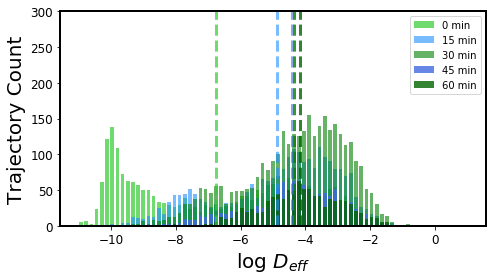

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

np_size = '100'

t0_100nm_2 = pd.read_csv('HYase_trial_2_{}nm_t0.csv'.format(np_size))
t15_100nm_2 = pd.read_csv('HYase_trial_2_{}nm_t15.csv'.format(np_size))
t30_100nm_2 = pd.read_csv('HYase_trial_2_{}nm_t30.csv'.format(np_size))
t45_100nm_2 = pd.read_csv('HYase_trial_2_{}nm_t45.csv'.format(np_size))
t60_100nm_2 = pd.read_csv('HYase_trial_2_{}nm_t60.csv'.format(np_size))

t0_100nm_2_no_nan = t0_100nm_2.replace(0,np.nan)
t15_100nm_2_no_nan = t15_100nm_2.replace(0,np.nan)
t30_100nm_2_no_nan = t30_100nm_2.replace(0,np.nan)
t45_100nm_2_no_nan = t45_100nm_2.replace(0,np.nan)
t60_100nm_2_no_nan = t60_100nm_2.replace(0,np.nan)

log_Deff_t0_100 = np.log(t0_100nm_2_no_nan.dropna())
log_Deff_t15_100 = np.log(t15_100nm_2_no_nan.dropna())
log_Deff_t30_100 = np.log(t30_100nm_2_no_nan.dropna())
log_Deff_t45_100 = np.log(t45_100nm_2_no_nan.dropna())
log_Deff_t60_100 = np.log(t60_100nm_2_no_nan.dropna())

test_bins = np.linspace(-11, 1, 76)

t0_hist_100, t0_bins_100 = np.histogram(log_Deff_t0_100, bins=test_bins)
t15_hist_100, t15_bins_100 = np.histogram(log_Deff_t15_100, bins=test_bins)
t30_hist_100, t30_bins_100 = np.histogram(log_Deff_t30_100, bins=test_bins)
t45_hist_100, t45_bins_100 = np.histogram(log_Deff_t45_100, bins=test_bins)
t60_hist_100, t60_bins_100 = np.histogram(log_Deff_t60_100, bins=test_bins)

t0_avg_100 = np.mean(log_Deff_t0_100)[0]
t15_avg_100 = np.mean(log_Deff_t15_100)[0]
t30_avg_100 = np.mean(log_Deff_t30_100)[0]
t45_avg_100 = np.mean(log_Deff_t45_100)[0]
t60_avg_100 = np.mean(log_Deff_t60_100)[0]

plt.rc('axes', linewidth=2)
t0_plot_100, t15_plot_100, t30_plot_100 = t0_hist_100, t15_hist_100, t30_hist_100
t45_plot_100, t60_plot_100 = t45_hist_100, t60_hist_100

bins = test_bins
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:])/2

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, t0_plot_100, color='limegreen', align='center', width=width, alpha=0.7, label='0 min')
plt.axvline(t0_avg_100, color='limegreen', linestyle='--', alpha=0.7, linewidth=3)
plt.ylim((0,800))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, t15_plot_100, color='dodgerblue', align='center', width=width, alpha=0.6, label='15 min')
plt.axvline(t15_avg_100, color='dodgerblue', linestyle='--', alpha=0.6, linewidth=3)
plt.ylim((0,400))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, t30_plot_100, color='green',  align='center', width=width, alpha=0.6, label='30 min')
plt.axvline(t30_avg_100, color='green', linestyle='--', alpha=0.8, linewidth=3)
plt.ylim((0,100))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, t45_plot_100, color='royalblue',  align='center', width=width, alpha=0.8, label='45 min')
plt.axvline(t45_avg_100, color='royalblue', linestyle='--', alpha=0.6, linewidth=3)
plt.ylim((0,100))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, t60_plot_100, color='darkgreen',  align='center', width=width, alpha=0.8, label='60 min')
plt.axvline(t60_avg_100, color='darkgreen', linestyle='--', alpha=0.8, linewidth=3)
plt.ylim((0,100))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.ylim((0,300))
plt.legend()
plt.show()

In [22]:
print(t0_avg_100, t15_avg_100, t30_avg_100, t45_avg_100, t60_avg_100)
print(np.exp(t0_avg_100), np.exp(t15_avg_100), np.exp(t30_avg_100), np.exp(t45_avg_100), np.exp(t60_avg_100))

-6.76603604042 -4.87625163815 -4.35663117978 -4.42241247898 -4.15329789196
0.00115225309488 0.00762554382171 0.0128215083323 0.012005234944 0.0157125127759
